In [43]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns

# Sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

# Sklearn models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

# Keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

Directory layout of data:
```
data
|--- vgsales
     |--- vgsales.csv
```

In [44]:
import warnings
warnings.filterwarnings('ignore') # To keep the final notebook clean

# Reading in + inspecting the data

We'll start by reading in the video game sales data and examining the available features.

In [45]:
# Read in data
vgsales = pd.read_csv('/content/data/vgsales/vgsales.csv')

In [46]:
vgsales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [47]:
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


# Data preprocessing

Fortunately, the data is fairly complete! However, there are a few areas for cleanup and improvement that I identified during my data exploration--below is a walkthrough of the steps I took to process my data and add useful new features.

We start by dropping all rows containing nulls in any important columns.

In [48]:
# Drop rows with nulls in any important columns
vgsales = vgsales.dropna(subset=['Year', 'Publisher', 'Name', 'Global_Sales'])

# Recast 'Year' from string to int
vgsales['Year'] = vgsales['Year'].astype(int)

## Restricting date range for dataset

I noticed that the total volume of games sold (and thus the total revenue) increased significantly between the 90s and the 2000s onward. While this could itself pose an interesting time series problem, my main focus in this analysis is to predict sales for new games published from today onwards. So, to keep the numbers within a consistent range and avoid confusing my later models, I've chosen to restrict the year range. I've selected this range based on the graph generated below:

In [49]:
# Calculate the total video game sales for each year in the dataset, and put into a dict
min_year = vgsales['Year'].min()
max_year = vgsales['Year'].max()

sales_per_year = {}
for y in range(min_year, max_year+1):
  # Pull out all records from the vgsales df from that year, and sum up their Global_Sales column
  relevant_records = vgsales[vgsales['Year']==y]
  total = relevant_records['Year'].sum()
  sales_per_year[int(y)] = total

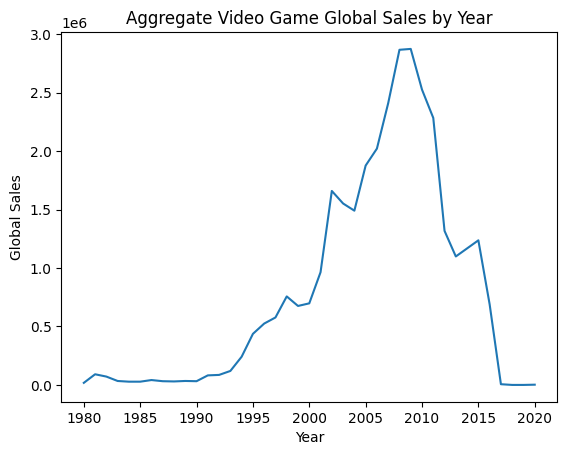

In [50]:
sales_per_year_df = pd.DataFrame({'Year': sales_per_year.keys(), 'Sales': sales_per_year.values()})
plt.plot(sales_per_year_df['Year'], sales_per_year_df['Sales'])
plt.xlabel("Year")
plt.ylabel("Global Sales")
plt.title("Aggregate Video Game Global Sales by Year")
plt.show()

From this, I've decided to subset down to the range 2002-2015. (I believe the lack of games from 2016 onwards is due to incompleteness in the dataset I'm working with, so unfortunately I've had to exclude 2016 onwards).

In [51]:
vgsales = vgsales[(vgsales['Year'] >= 2002) & (vgsales['Year'] <= 2015)]

## Consolidating repeat entries for publishers

While exploring the data, I noticed that some publishers are listed multiple times under slight variations (e.g. Sony Computer Entertainment, Sony Computer Entertainment Europe, etc). For our purposes, we care more about the publishers as an overarching brand where applicable, so I've added a step to consolidate the publisher column for a few major publishers.

In [52]:
unique_publishers = vgsales['Publisher'].unique()

In [53]:
[p for p in list(unique_publishers) if 'Ubisoft' in p]

['Ubisoft', 'Ubisoft Annecy']

In [54]:
[p for p in list(unique_publishers) if 'Sony' in p]

['Sony Computer Entertainment',
 'Sony Computer Entertainment Europe',
 'Sony Online Entertainment',
 'Sony Computer Entertainment America']

There might be a benefit from consolidating all the Ubisoft and Sony ones respectively.

In [55]:
def pub_mapper(name):
  if 'Sony' in name:
    return 'Sony'
  elif 'Ubisoft' in name:
    return 'Ubisoft'
  return name
vgsales['Publisher_Consolidated'] = vgsales.apply(lambda x: pub_mapper(x[5]), axis=1, raw=True)

## Adding a 'Franchise' feature

Many games are released as part of a franchise (e.g. Super Mario games, FIFA games, Pokemon games), and games within the same franchise tend to sell similarly to one another. Additionally, games from popular franchises (like the examples listed above) tend to sell better than other games, so this could be a useful bit of information for regression models. Below, I've manually constructed a list of the top most popular franchises from [Wikipedia](https://en.wikipedia.org/wiki/List_of_best-selling_video_game_franchises), and set up some code to add a new 'Franchise' column to the dataset.

In [56]:
unique_names = vgsales['Name'].unique()
unique_names

array(['Wii Sports', 'Mario Kart Wii', 'Wii Sports Resort', ...,
       'Plushees', 'Woody Woodpecker in Crazy Castle 5', 'Know How 2'],
      dtype=object)

In [57]:
# Manually construct a list of some of the most popular franchises (from https://en.wikipedia.org/wiki/List_of_best-selling_video_game_franchises)
franchises = ['Pokemon',
              'Fire Emblem',
              'Wii Sports',
              'Mario Kart',
              'Super Mario',
              'Mario',
              'Kirby',
              'Metroid',
              'Tetris',
              'Grand Theft Auto',
              'Call of Duty',
              'FIFA',
              'Minecraft',
              'Final Fantasy',
              "Assassin's Creed",
              "Sonic",
              "Resident Evil",
              "Zelda",
              "NBA",
              "Madden",
              "Star Wars",
              "Monster Hunter"
              ]
print("Games in each franchise")
for f in franchises:
  ct = len([n for n in unique_names if f in n])
  print(f"{f}: {ct}")

Games in each franchise
Pokemon: 28
Fire Emblem: 10
Wii Sports: 3
Mario Kart: 6
Super Mario: 18
Mario: 71
Kirby: 12
Metroid: 10
Tetris: 9
Grand Theft Auto: 10
Call of Duty: 19
FIFA: 29
Minecraft: 2
Final Fantasy: 50
Assassin's Creed: 14
Sonic: 39
Resident Evil: 23
Zelda: 14
NBA: 56
Madden: 16
Star Wars: 37
Monster Hunter: 16


In [58]:
# Use this function with df.apply to create a new column of franchises
def add_franchise(title):
  for f in franchises:
    if f in title:
      return f
  return ""

vgsales['Franchise'] = vgsales.apply(lambda x: add_franchise(x[1]), raw=True, axis=1)

## Adding a 'Title Length' feature
As another attempt to extract meaningful info from the title feature, I'm adding a feature containing the length of each game's title. I believe this feature could really go either way in terms of predicting game sales--some great games have had somewhat long titles (e.g. most Zelda games), but a lot of classic and iconic games also had very short games (Tetris, Wii Sports). We'll see how the models make use of this feature, if at all!

In [59]:
vgsales['Title_Length'] = vgsales.apply(lambda x: len(x[1]), raw=True, axis=1)
vgsales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Publisher_Consolidated,Franchise,Title_Length
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo,Wii Sports,10
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo,Mario Kart,14
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo,Wii Sports,17
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,Nintendo,Super Mario,21
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,Nintendo,,8


In [60]:
# Let's see what our dataframe looks like after all the cleaning and feature engineering
vgsales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Publisher_Consolidated,Franchise,Title_Length
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo,Wii Sports,10
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo,Mario Kart,14
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo,Wii Sports,17
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,Nintendo,Super Mario,21
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,Nintendo,,8


In [61]:
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13140 entries, 0 to 16597
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rank                    13140 non-null  int64  
 1   Name                    13140 non-null  object 
 2   Platform                13140 non-null  object 
 3   Year                    13140 non-null  int64  
 4   Genre                   13140 non-null  object 
 5   Publisher               13140 non-null  object 
 6   NA_Sales                13140 non-null  float64
 7   EU_Sales                13140 non-null  float64
 8   JP_Sales                13140 non-null  float64
 9   Other_Sales             13140 non-null  float64
 10  Global_Sales            13140 non-null  float64
 11  Publisher_Consolidated  13140 non-null  object 
 12  Franchise               13140 non-null  object 
 13  Title_Length            13140 non-null  int64  
dtypes: float64(5), int64(3), object(6)
memory u

# Visualizations

Now that we've got a clean dataset, this is a good opportunity to stop and examine the distribution of some key features, particularly how they relate to our target feature (global sales). In this section, I'll be generating some visualizations for various features in the dataset, to give us some intuition about what features drive video game sales.

## Visualize distribution of global sales

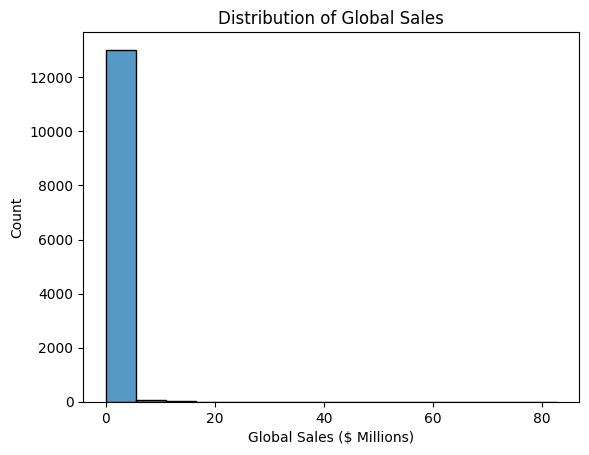

In [62]:
# Generate a histogram of Global_Sales
fig = sns.histplot(data=vgsales, x='Global_Sales', bins=15)
plt.title("Distribution of Global Sales")
plt.xlabel("Global Sales ($ Millions)")
plt.ylabel("Count")
plt.show()

We can see that it's tough to visualize this data with a histogram, since most games sell in the range of \$0-5 million, while a handful of games sell significantly more (up to $80 million). To improve this visualization, I'm going to split the data into two groups (the average-selling games, and the high-selling ones) and make two visualizations.

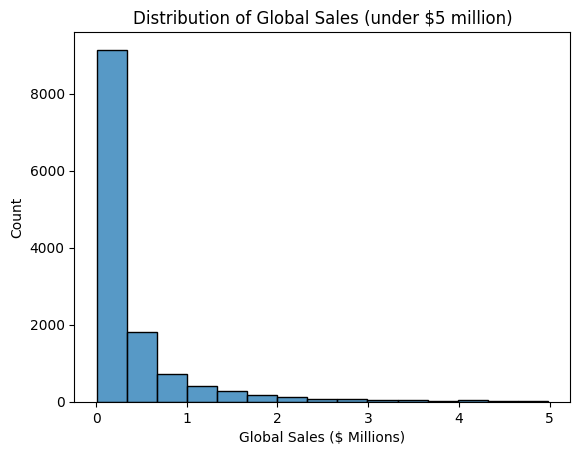

In [63]:
# Generate a histogram of Global_Sales for games under $5 million in sales
fig = sns.histplot(data=vgsales[vgsales['Global_Sales'] < 5], x='Global_Sales', bins=15)
plt.title("Distribution of Global Sales (under $5 million)")
plt.xlabel("Global Sales ($ Millions)")
plt.ylabel("Count")
plt.show()

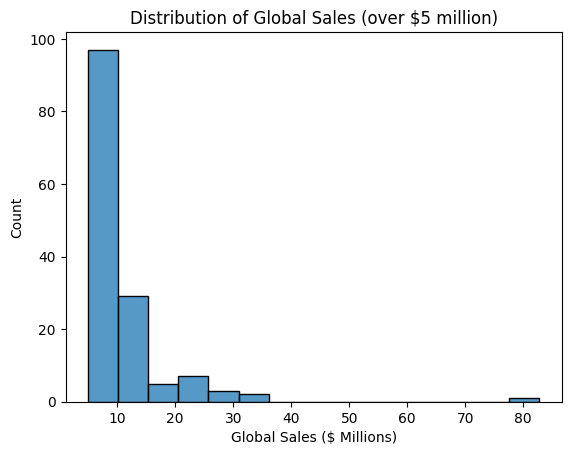

In [64]:
# Generate a histogram of Global_Sales for games over $5 million in sales
fig = sns.histplot(data=vgsales[vgsales['Global_Sales'] >= 5], x='Global_Sales', bins=15)
plt.title("Distribution of Global Sales (over $5 million)")
plt.xlabel("Global Sales ($ Millions)")
plt.ylabel("Count")
plt.show()

As we can see, the *vast* majority of games sell below \$5 million dollars in total. There are a nontrivial amount of games that sell above \$5 million, but it's a very small amount compared to the under-$5 million games.

## Visualize global sales grouped by publisher

In [65]:
# Bar plot of sales by publisher, using sns
# Select out the top 10 most popular publishers first
df_sales_by_publisher = vgsales.groupby(by=['Publisher_Consolidated']).sum()[['Global_Sales']]
top_publishers = df_sales_by_publisher.reset_index().sort_values(by=['Global_Sales'], ascending=False)['Publisher_Consolidated'][:10]

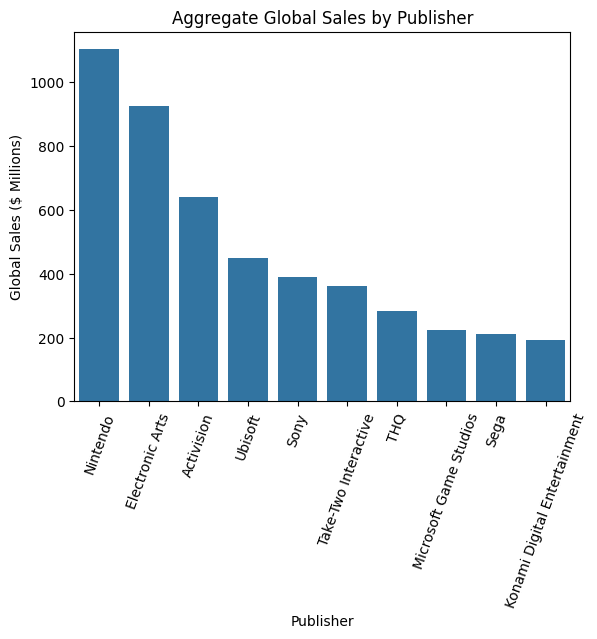

In [66]:
fig = sns.barplot(data=df_sales_by_publisher.loc[top_publishers], x='Publisher_Consolidated', y='Global_Sales')
plt.xticks(rotation=70)
plt.title("Aggregate Global Sales by Publisher")
plt.xlabel("Publisher")
plt.ylabel("Global Sales ($ Millions)")
plt.show()


## Visualize global sales grouped by platform

In [67]:
# Plot sales by platform (again selecting for the top 10)
df_sales_by_platform = vgsales.groupby(by=['Platform']).sum()[['Global_Sales']]
top_platforms = df_sales_by_platform.reset_index().sort_values(by=['Global_Sales'], ascending=False)['Platform'][:10]

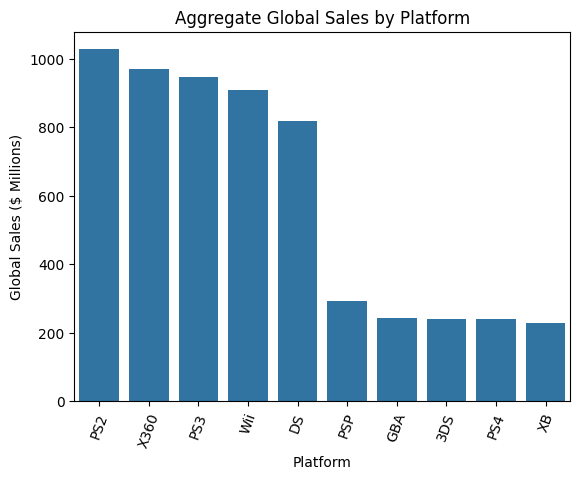

In [68]:
fig = sns.barplot(data=df_sales_by_platform.loc[top_platforms], x='Platform', y='Global_Sales')
plt.xticks(rotation=70)
plt.title("Aggregate Global Sales by Platform")
plt.xlabel("Platform")
plt.ylabel("Global Sales ($ Millions)")
plt.show()


## Visualize global sales grouped by game genre

In [69]:
# And finally, plot the aggregate sales of games based on game genre
# Plot sales by platform (again selecting for the top 10)
df_sales_by_genre = vgsales.groupby(by=['Genre']).sum()[['Global_Sales']]
top_genres = df_sales_by_genre.reset_index().sort_values(by=['Global_Sales'], ascending=False)['Genre'][:10]

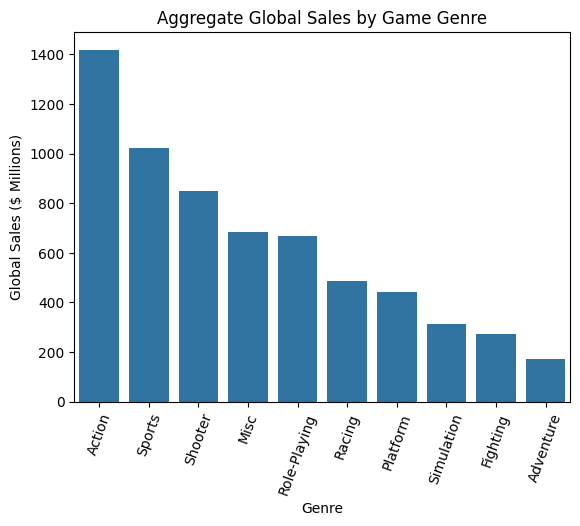

In [70]:
fig = sns.barplot(data=df_sales_by_genre.loc[top_genres], x='Genre', y='Global_Sales')
plt.xticks(rotation=70)
plt.title("Aggregate Global Sales by Game Genre")
plt.xlabel("Genre")
plt.ylabel("Global Sales ($ Millions)")
plt.show()


# Establishing a baseline

Before we start modeling, I want to establish a baseline. I'll use a simple baseline here--if we had a model that simply predicted the mean Global_Sales number (from the preprocessed dataset), what MSE and MAE would we get?

In [71]:
mean_global_sales = vgsales['Global_Sales'].mean()
mean_global_sales

0.49864611872146125

In [72]:
# Calculate MSE for this (on the full dataset)
mean_squared_error(vgsales['Global_Sales'], [mean_global_sales]*np.ones(len(vgsales)))

2.2659607469141596

In [73]:
# Also calculate MAE
mean_absolute_error(vgsales['Global_Sales'], [mean_global_sales]*np.ones(len(vgsales)))

0.5495565362134512

So, a MSE of 2.26 (or MAE of 0.55) is the baseline to beat.

# Model building

Now that we've done some data cleaning and feature engineering, it's time to try out some different models on the data and see what works well. For each model, I'll train an initial model (with default parameters), and then set up a grid search with cross-validation to see how much we can improve the performance with the selection of optimal hyperparameters.

## Test-train split

In [74]:
vgsales.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Publisher_Consolidated', 'Franchise', 'Title_Length'],
      dtype='object')

In [75]:
# Test train split
X = vgsales[['Platform', 'Genre', 'Publisher_Consolidated', 'Franchise', 'Title_Length']] # 'Name',
y = vgsales['Global_Sales']

In [76]:
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns.tolist()),  # Apply OneHotEncoder to object columns
        ('scale', StandardScaler(), X.select_dtypes(include=['int64']).columns.tolist())
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape

((9855, 5), (9855,))

## Logistic regression

In [79]:
# Set up a pipeline that uses OHE and then runs linear regression
lr_pipe = Pipeline([('ct', column_transformer), ('linreg', LinearRegression())])
lr_pipe.fit(X_train, y_train)
lr_train_preds = lr_pipe.predict(X_train)
lr_test_preds = lr_pipe.predict(X_test)
lr_train_mse = mean_squared_error(y_train, lr_train_preds)
lr_test_mse = mean_squared_error(y_test, lr_test_preds)
lr_train_mse, lr_test_mse

(1.1791600500283457, 2.596872532458826)

In [80]:
mean_absolute_error(y_train, lr_train_preds), mean_absolute_error(y_test, lr_test_preds)

(0.4430532290031946, 0.4923091016373915)

Looks like some overfitting is going on here, based on the MSE. Let's see if we can improve that with Lasso or Ridge.

## Lasso

In [119]:
# Set up a pipeline that uses OHE and then runs Lasso regression (initially with default params)
lasso_pipe = Pipeline([('ct', column_transformer), ('lasso', Lasso())])
lasso_pipe.fit(X_train, y_train)
lasso_train_preds = lasso_pipe.predict(X_train)
lasso_test_preds = lasso_pipe.predict(X_test)
lasso_train_mse = mean_squared_error(y_train, lasso_train_preds)
lasso_test_mse = mean_squared_error(y_test, lasso_test_preds)
lasso_train_mse, lasso_test_mse

(1.7450640212971391, 3.8292746053339104)

In [404]:
# Also compute MAE
mean_absolute_error(y_train, lasso_train_preds), mean_absolute_error(y_test, lasso_test_preds)

(0.5320950803391954, 0.5747292344783222)

Let's try grid searching for some better parameters

In [120]:
lasso_pipe = Pipeline([('ct', column_transformer), ('lasso', Lasso())])
lasso_grid = GridSearchCV(lasso_pipe, param_grid={'lasso__alpha': [0.1, 1.0, 2.0, 5.0, 10.0]})
lasso_grid.fit(X_train, y_train)
lasso_train_mse = mean_squared_error(y_train, lasso_grid.predict(X_train))
lasso_test_mse = mean_squared_error(y_test, lasso_grid.predict(X_test))
lasso_train_mse, lasso_test_mse

(1.7450640212971391, 3.8292746053339104)

In [405]:
# Also compute MAE
mean_absolute_error(y_train, lasso_grid.predict(X_train)), mean_absolute_error(y_test, lasso_grid.predict(X_test))

(0.5320950803391954, 0.5747292344783222)

In [406]:
lasso_grid.best_params_

{'lasso__alpha': 0.1}

## Ridge

In [409]:
# Set up a pipeline that uses OHE and then runs Ridge regression (initially with default params)
ridge_pipe = Pipeline([('ct', column_transformer), ('ridge', Ridge())])
ridge_pipe.fit(X_train, y_train)
ridge_train_preds = ridge_pipe.predict(X_train)
ridge_test_preds = ridge_pipe.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
ridge_train_mse, ridge_test_mse

(1.1872082356076887, 2.759246475492697)

In [410]:
# Also compute MAE
mean_absolute_error(y_train, ridge_train_preds), mean_absolute_error(y_test, ridge_test_preds)

(0.4445456913919628, 0.4904619676542943)

In [411]:
# Grid search for better parameters to reduce overfitting
ridge_pipe = Pipeline([('ct', column_transformer), ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid={'ridge__alpha': np.arange(3, 8, 0.5)})
ridge_grid.fit(X_train, y_train)
ridge_train_mse = mean_squared_error(y_train, ridge_grid.predict(X_train))
ridge_test_mse = mean_squared_error(y_test, ridge_grid.predict(X_test))
ridge_train_mse, ridge_test_mse

(1.2212620652635655, 2.9558055152807676)

In [412]:
mean_absolute_error(y_train, ridge_grid.predict(X_train)), mean_absolute_error(y_test, ridge_grid.predict(X_test))

(0.447080974417036, 0.4907184233203325)

In [413]:
ridge_grid.best_params_

{'ridge__alpha': 4.0}

## Decision Tree (Regression)

In [414]:
dt_pipe = Pipeline([('ct', column_transformer), ('dt', DecisionTreeRegressor())])
dt_pipe.fit(X_train, y_train)
dt_train_mse = mean_squared_error(y_train, dt_pipe.predict(X_train))
dt_test_mse = mean_squared_error(y_test, dt_pipe.predict(X_test))
dt_train_mse, dt_test_mse

(0.0656697717579506, 3.669659044503439)

In [416]:
# Also compute MAE
mean_absolute_error(y_train, dt_pipe.predict(X_train)), mean_absolute_error(y_test, dt_pipe.predict(X_test))

(0.057358885587043884, 0.48164300814186656)

In [421]:
# Grid search for better parameters to reduce overfitting
dt_pipe = Pipeline([('ct', column_transformer), ('dt', DecisionTreeRegressor())])
dt_grid = GridSearchCV(dt_pipe, cv=10, param_grid={'dt__max_depth': range(3, 15), 'dt__min_samples_leaf': range(1, 5), 'dt__min_samples_split': range(2, 9)})
dt_grid.fit(X_train, y_train)
dt_train_mse = mean_squared_error(y_train, dt_grid.predict(X_train))
dt_test_mse = mean_squared_error(y_test, dt_grid.predict(X_test))
dt_train_mse, dt_test_mse

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


(0.8538623130536305, 3.1447833600370885)

In [422]:
mean_absolute_error(y_train, dt_grid.predict(X_train)), mean_absolute_error(y_test, dt_grid.predict(X_test))

(0.3546928682159831, 0.45565292662043205)

In [423]:
dt_grid.best_params_

{'dt__max_depth': 14, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 4}

## Neural Net

Below, I experimented with using a neural net for this task, and tweaking various attributes (model architecture, learning rate, etc) to see what gave me the best test performance. At the bottom of this section, I've included a graph of training and validation loss over the training epochs for the best-performing model.

In [319]:
# We need to create a transformed version of X to pass into the NN, since we can't do a pipeline like with
# the previous models.
X_transf = column_transformer.fit_transform(X)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_transf, y, test_size=0.2, random_state=423)

In [321]:
# Set up early stopping to use in the following NN models
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [322]:
model = Sequential()

model.add(Dense(64, activation='relu', input_dim=X_train_nn.shape[1]))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1))  # Output layer for regression

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [323]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
history = model.fit(X_train_nn, y_train_nn, validation_split=0.3, epochs=50, batch_size=64, callbacks=[early_stopping])

In [368]:
model.evaluate(X_train_nn, y_train_nn)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4741 - mae: 0.2840 - mse: 0.4741


[0.8667646050453186, 0.3238902986049652, 0.8667646050453186]

In [325]:
model.evaluate(X_test_nn, y_test_nn)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1530 - mae: 0.4442 - mse: 1.1530


[1.3558634519577026, 0.44958311319351196, 1.3558634519577026]

### Adding dropout

In [327]:
model2 = Sequential()

model2.add(Dense(64, activation='relu', input_dim=X_train_nn.shape[1]))  # Input layer
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu'))  # Hidden layer
model2.add(Dropout(0.5))
model2.add(Dense(1))  # Output layer for regression

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [328]:
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
history2 = model2.fit(X_train_nn, y_train_nn, validation_split=0.3, epochs=50, batch_size=64, callbacks=[early_stopping])

In [330]:
model2.evaluate(X_train_nn, y_train_nn)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6690 - mae: 0.4485 - mse: 1.6690


[2.2472739219665527, 0.4514590799808502, 2.2472739219665527]

In [331]:
model2.evaluate(X_test_nn, y_test_nn)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3482 - mae: 0.4499 - mse: 1.3482


[1.800836443901062, 0.4613015353679657, 1.800836443901062]

Great! Let's try to keep improving.

### Adding another hidden layer

In [333]:
model3 = Sequential()

model3.add(Dense(64, activation='relu', input_dim=X_train_nn.shape[1]))  # Input layer
model3.add(Dropout(0.5))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='relu'))  # Hidden layer
model3.add(Dense(1))  # Output layer for regression

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [334]:
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
history3 = model3.fit(X_train_nn, y_train_nn, validation_split=0.3, epochs=50, batch_size=64, callbacks=[early_stopping])

In [336]:
model3.evaluate(X_train_nn, y_train_nn)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6117 - mae: 0.4426 - mse: 1.6117


[2.194077968597412, 0.445878267288208, 2.194077968597412]

In [337]:
model3.evaluate(X_test_nn, y_test_nn)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2875 - mae: 0.4464 - mse: 1.2875


[1.7550827264785767, 0.4587528109550476, 1.7550827264785767]

### Increasing dropout after first layer

In [349]:
model4 = Sequential()

model4.add(Dense(64, activation='relu', input_dim=X_train_nn.shape[1]))  # Input layer
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu'))  # Hidden layer
model4.add(Dense(1))  # Output layer for regression

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [350]:
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
history4 = model4.fit(X_train_nn, y_train_nn, validation_split=0.3, epochs=50, batch_size=64, callbacks=[early_stopping])

In [352]:
model4.evaluate(X_train_nn, y_train_nn)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7021 - mae: 0.4826 - mse: 1.7021


[2.282822608947754, 0.48534566164016724, 2.282822608947754]

In [353]:
model4.evaluate(X_test_nn, y_test_nn)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3592 - mae: 0.4810 - mse: 1.3592


[1.8234480619430542, 0.491789847612381, 1.8234480619430542]

### Changing the shape of the input and hidden layers

In [354]:
model5 = Sequential()

model5.add(Dense(100, activation='relu', input_dim=X_train_nn.shape[1]))  # Input layer
model5.add(Dropout(0.5))
model5.add(Dense(50, activation='relu'))  # Hidden layer
model5.add(Dropout(0.5))
model5.add(Dense(15, activation='relu'))  # Hidden layer
model5.add(Dense(1))  # Output layer for regression

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [355]:
model5.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
history5 = model5.fit(X_train_nn, y_train_nn, validation_split=0.3, epochs=50, batch_size=64, callbacks=[early_stopping])

In [357]:
model5.evaluate(X_train_nn, y_train_nn)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6079 - mae: 0.4315 - mse: 1.6079


[2.188674211502075, 0.4334506392478943, 2.188674211502075]

In [358]:
model5.evaluate(X_test_nn, y_test_nn)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2845 - mae: 0.4350 - mse: 1.2845


[1.7510125637054443, 0.4466076195240021, 1.7510125637054443]

In [287]:
model.save('models/model5_1.keras')

### Changing learning rate (and removing early stopping)

In [369]:
optimizer = tf.keras.optimizers.Adam(0.003)

In [370]:
model6 = Sequential()

model6.add(Dense(100, activation='relu', input_dim=X_train_nn.shape[1]))  # Input layer
model6.add(Dropout(0.5))
model6.add(Dense(50, activation='relu'))  # Hidden layer
model6.add(Dropout(0.2))
model6.add(Dense(1))  # Output layer for regression

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [371]:
model6.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
history6 = model6.fit(X_train_nn, y_train_nn, validation_split=0.3, epochs=50, batch_size=64)

In [373]:
model6.evaluate(X_train_nn, y_train_nn)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5301 - mae: 0.3328 - mse: 0.5301


[0.9318727850914001, 0.3569142520427704, 0.9318727850914001]

In [374]:
model6.evaluate(X_test_nn, y_test_nn)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0528 - mae: 0.4269 - mse: 1.0528


[1.2899492979049683, 0.43281444907188416, 1.2899492979049683]

### Adding in another hidden layer

In [388]:
optimizer = tf.keras.optimizers.Adam(0.003)

In [ ]:
model7 = Sequential()

model7.add(Dense(100, activation='relu', input_dim=X_train_nn.shape[1]))  # Input layer
model7.add(Dropout(0.5))
model7.add(Dense(50, activation='relu'))  # Hidden layer
model7.add(Dropout(0.2))
model7.add(Dense(15, activation='relu'))  # Hidden layer
model7.add(Dense(1))  # Output layer for regression

In [390]:
model7.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

In [ ]:
history7 = model7.fit(X_train_nn, y_train_nn, validation_split=0.3, epochs=70, batch_size=30)

In [395]:
model7.evaluate(X_train_nn, y_train_nn)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5453 - mae: 0.3271 - mse: 0.5453


[1.0046710968017578, 0.3507961928844452, 1.0046710968017578]

In [396]:
model7.evaluate(X_test_nn, y_test_nn)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0356 - mae: 0.4183 - mse: 1.0356


[1.2859277725219727, 0.4281722903251648, 1.2859277725219727]

### Plotting the loss for my best-performing NN model

The best performing NN model is model6 (i.e. the second-to-last model), so I'll plot the history of its training to see how the loss evolved over time.

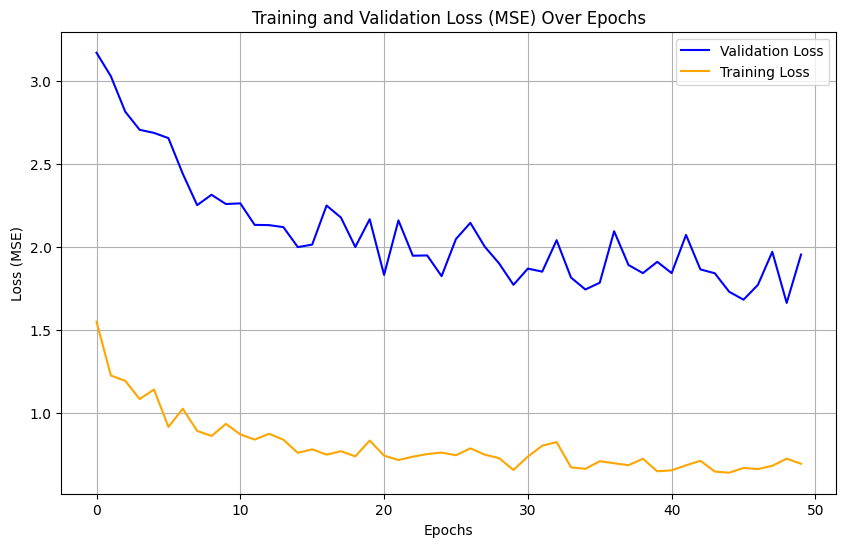

In [401]:
# Plot the validation loss for my best-performing model
plt.figure(figsize=(10, 6))
plt.plot(history6.history['val_loss'], label='Validation Loss', color='blue')
plt.plot(history6.history['loss'], label='Training Loss', color='orange')
plt.title('Training and Validation Loss (MSE) Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()